### Corridor Gridworld Example

Consider the small corridor gridworld shown inset in the graph below. The reward is **−1 per step**, as usual. In each of the three nonterminal states there are only two actions: **right** and **left**.

* These actions have their usual consequences in the first and third states (left causes no movement in the first state).
* In the **second state**, however, they are **reversed**, so that **right moves to the left** and **left moves to the right**.

The problem is difficult because all the states appear identical under the function approximation. In particular, we define:

$$
x(s, \text{right}) = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}, \quad 
x(s, \text{left}) = 
\begin{bmatrix}
0 \\
1
\end{bmatrix}, \quad \forall s
$$

---

### Action-Value Method

An action-value method with **ε-greedy action selection** is forced to choose between just two policies:

* Choosing **right** with high probability $1 - \varepsilon/2$ on all steps.
* Choosing **left** with the same high probability on all steps.

If $\varepsilon = 0.1$, then:

* The **right policy** achieves a value (at the start state) of **less than −44**.
* The **left policy** achieves a value of **less than −82**.

(as shown in the graph).

---

### Optimal Stochastic Policy

A method can do significantly better if it can learn a specific probability with which to select **right**.

* The best probability is about **0.59**,
* This achieves a value of about **−11.6**.


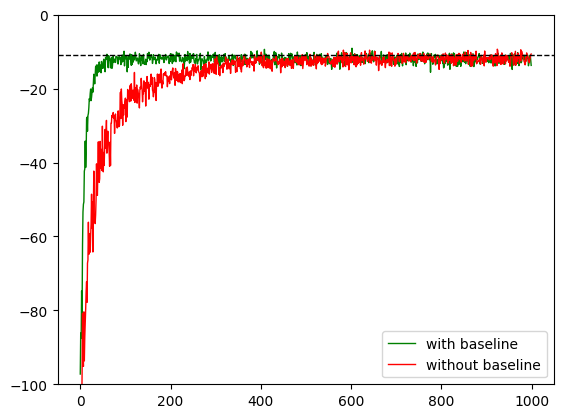

In [7]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import numpy as onp
from autograd import grad

states = np.arange(0, 3)
actions = ['left', 'right']

def action_feature_vector(s, a):
    if a == 'left':
        return np.array([0, 1])
    else:
        return np.array([1, 0])

def state_feature_vector(s):
    vec = np.zeros(3)
    vec[s] = 1
    return vec

def get_next_state_and_reward(s, a):
    direction = 1 if a == 'right' else -1
    if s == 1:
        direction *= -1
    next_state = s + direction
    if next_state < 0:
        next_state = 0
    return next_state, -1

def pi(s, a, theta):
    return np.exp(np.dot(theta, action_feature_vector(s, a))) / np.sum([np.exp(np.dot(theta, action_feature_vector(s, act))) for act in actions])

def v(s, w):
    return np.dot(w, state_feature_vector(s))

def generate_episode(theta, max_steps=300):
    episode = []
    state = 0
    while state != 3 and len(episode) < max_steps:
        action = onp.random.choice(actions, p=[pi(state, a, theta) for a in actions])
        next_state, reward = get_next_state_and_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def reinforce(policy, alpha = 2 ** -12, gamma = 1.0, num_episodes = 1000):
    returns = []

    theta = np.array([2.0, -2.0])
    for _ in range(num_episodes):
        frozen_theta = theta.copy()
        episode = generate_episode(frozen_theta)
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            logpi = lambda theta: np.log(policy(state, action, theta))
            grad_logpi = grad(logpi)(frozen_theta)
            theta += alpha * G * grad_logpi
        returns.append(G)
    return theta, returns

def reinforce_with_baseline(policy, alpha_theta = 2 ** -9, alpha_w = 2 ** -6, gamma = 1.0, num_episodes = 1000):
    returns = []

    theta = np.array([2.0, -2.0])
    w = np.array([0.0, 0.0, 0.0])
    for _ in range(num_episodes):
        frozen_theta = theta.copy()
        frozen_w = w.copy()
        episode = generate_episode(frozen_theta)
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            delta = G - v(state, frozen_w)
            w += alpha_w * delta * state_feature_vector(state)
            logpi = lambda theta: np.log(policy(state, action, theta))
            grad_logpi = grad(logpi)(frozen_theta)
            theta += alpha_theta * delta * grad_logpi
        returns.append(G)
    return theta, returns

def get_100_run_return_avg(learning_algo):
    all_run_returns = []
    for _ in range(100):
        _, episode_returns = learning_algo(pi)
        all_run_returns.append(onp.asarray(episode_returns))
    return onp.mean(onp.stack(all_run_returns, axis=0), axis=0)

returns_13_reinforce = get_100_run_return_avg(reinforce)
returns_13_reinforce_with_baseline = get_100_run_return_avg(reinforce_with_baseline)
plt.plot(returns_13_reinforce_with_baseline, label='with baseline', color='green', linewidth=1)
plt.plot(returns_13_reinforce, label='without baseline', color='red', linewidth=1)
plt.axhline(y=-11, color='black', linestyle='--', linewidth=1)
plt.ylim(-100, 0)
plt.legend()
plt.show()